<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 2
<br>
<b>Deadline:</b> March 17, 2021 (Wednesday) 23:00
</div>

# Exercise 3.1. Convolutional neural networks. LeNet-5.

In this exercise, you will train a very simple convolutional neural network used for image classification tasks.

If you are not fluent with PyTorch, you may find it useful to look at this tutorial:
* [Neural Networks](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py)

In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tools
import tests

In [ ]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [ ]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [ ]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## FashionMNIST dataset

Let us use the FashionMNIST dataset. It consists of 60,000 training images of 10 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

trainset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)

Let us visualize the data.

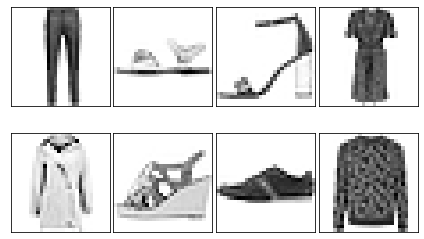

In [ ]:
images, labels = iter(trainloader).next()
tests.plot_images(images[:8], n_rows=2)

# 1. Simple convolutional network

In the first exercise, your task is to create a convolutional neural network with the architecture inspired by the classical LeNet-5 [(LeCun et al., 1998)](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

The architecture of the convolutional network that you need to create:
* 2d convolutional layer with:
    * one input channel
    * 6 output channels
    * kernel size 5 (no padding)
    * followed by ReLU
* Max-pooling layer with kernel size 2 and stride 2
* 2d convolutional layer with:
    * 16 output channels
    * kernel size 5 (no padding)
    * followed by ReLU
* Max-pooling layer with kernel size 2 and stride 2
* A fully-connected layer with:
    * 120 outputs
    * followed by ReLU
* A fully-connected layer with:
    * 84 outputs
    * followed by ReLU
* A fully-connected layer with 10 outputs and without nonlinearity.

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # YOUR CODE HERE
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(256,120)
        self.fc2 = nn.Linear(120,84)
        self.out = nn.Linear(84, 10)

    def forward(self, x):
        """
        Args:
          x of shape (batch_size, 1, 28, 28): Input images.
        
        Returns:
          y of shape (batch_size, 10): Outputs of the network.
        """
        # YOUR CODE HERE
        x = F.max_pool2d(F.relu(self.conv1(x)),2, 2)
        x = F.max_pool2d(F.relu(self.conv2(x)),2, 2)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = self.out(x)
        return y

In [ ]:
def test_LeNet5_shapes():
    net = LeNet5()

    # Feed a batch of images from the training data to test the network
    with torch.no_grad():
        images, labels = iter(trainloader).next()
        print('Shape of the input tensor:', images.shape)

        y = net(images)
        assert y.shape == torch.Size([trainloader.batch_size, 10]), "Bad shape of y: y.shape={}".format(y.shape)

    print('Success')

test_LeNet5_shapes()

Shape of the input tensor: torch.Size([32, 1, 28, 28])
Success


In [ ]:

net = LeNet5()
print(net)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
tests.test_LeNet5(LeNet5)

y: tensor([[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000]], grad_fn=<AddmmBackward>)
expected: tensor([ 1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.])
Success


# Train the network

In [ ]:
# This function computes the accuracy on the test dataset
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

### Training loop

Your task is to implement the training loop. The recommended hyperparameters:
* Stochastic Gradient Descent (SGD) optimizer with learning rate 0.001 and momentum 0.9.
* Cross-entropy loss. Note that we did not use softmax nonlinearity in the final layer of our network. Therefore, we need to use a loss function with log_softmax implemented, such as [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss).
* Number of epochs: 10. Please use mini-batches produces by `trainloader` defined above.

We recommend you to use function `compute_accuracy()` defined above to track the accuracy during training. The test accuracy should be above 0.87.

In [ ]:
# Create network
net = LeNet5()

In [ ]:
# Implement the training loop in this cell
if not skip_training:
    # YOUR CODE HERE
    net.train()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum = 0.9)
    criterion = nn.CrossEntropyLoss()
    epochs = 10
    
    for epoch in range(epochs):
        print("Epoch number:  ", epoch)
        for i, data in enumerate(trainloader, 0):
            images, labels = data
            optimizer.zero_grad()
            output = net(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            if i % 20 == 19:
                acc = compute_accuracy(net, testloader)
                print("Accuracy:  ", acc)
                net.train()

Epoch number:   0
Accuracy:   0.816
Accuracy:   0.8143
Accuracy:   0.8236
Accuracy:   0.8186
Accuracy:   0.8158
Accuracy:   0.8196
Accuracy:   0.8118
Accuracy:   0.8129
Accuracy:   0.8105
Accuracy:   0.8305
Accuracy:   0.8281
Accuracy:   0.836
Accuracy:   0.8318
Accuracy:   0.8217
Accuracy:   0.8039
Accuracy:   0.8204
Accuracy:   0.8302
Accuracy:   0.8365
Accuracy:   0.8223
Accuracy:   0.8211
Accuracy:   0.8172
Accuracy:   0.8219
Accuracy:   0.8388
Accuracy:   0.8272
Accuracy:   0.8353
Accuracy:   0.8369
Accuracy:   0.8422
Accuracy:   0.8064
Accuracy:   0.836
Accuracy:   0.8411
Accuracy:   0.8282
Accuracy:   0.8446
Accuracy:   0.8327
Accuracy:   0.837
Accuracy:   0.8397
Accuracy:   0.8382
Accuracy:   0.8385
Accuracy:   0.8387
Accuracy:   0.8454
Accuracy:   0.8461
Accuracy:   0.8415
Accuracy:   0.8399
Accuracy:   0.8458
Accuracy:   0.8409
Accuracy:   0.834
Accuracy:   0.8427
Accuracy:   0.8512
Accuracy:   0.843
Accuracy:   0.8483
Accuracy:   0.8493
Accuracy:   0.847
Accuracy:   0.8298
A

Accuracy:   0.8861
Accuracy:   0.8847
Accuracy:   0.8773
Accuracy:   0.8829
Accuracy:   0.8803
Accuracy:   0.8839
Accuracy:   0.8791
Accuracy:   0.8878
Accuracy:   0.8842
Accuracy:   0.8825
Accuracy:   0.8691
Accuracy:   0.8836
Accuracy:   0.8819
Accuracy:   0.8883
Accuracy:   0.8846
Accuracy:   0.8825
Accuracy:   0.8835
Accuracy:   0.8842
Accuracy:   0.8872
Accuracy:   0.882
Accuracy:   0.8826
Accuracy:   0.8872
Accuracy:   0.8807
Accuracy:   0.8868
Accuracy:   0.8882
Accuracy:   0.8845
Accuracy:   0.8917
Accuracy:   0.8857
Accuracy:   0.8857
Accuracy:   0.885
Accuracy:   0.8903
Accuracy:   0.8831
Accuracy:   0.8886
Accuracy:   0.8897
Accuracy:   0.8863
Accuracy:   0.8859
Epoch number:   5
Accuracy:   0.8883
Accuracy:   0.8893
Accuracy:   0.8891
Accuracy:   0.8863
Accuracy:   0.8638
Accuracy:   0.8826
Accuracy:   0.8777
Accuracy:   0.8859
Accuracy:   0.8787
Accuracy:   0.8866
Accuracy:   0.8824
Accuracy:   0.8839
Accuracy:   0.8851
Accuracy:   0.8826
Accuracy:   0.8886
Accuracy:   0.8

Accuracy:   0.8912
Accuracy:   0.8958
Accuracy:   0.8934
Accuracy:   0.8973
Accuracy:   0.893
Accuracy:   0.8963
Accuracy:   0.8978
Accuracy:   0.8963
Accuracy:   0.8908
Accuracy:   0.8915
Accuracy:   0.892
Accuracy:   0.8906
Accuracy:   0.8938
Accuracy:   0.8956
Accuracy:   0.8977
Accuracy:   0.8926
Accuracy:   0.892
Accuracy:   0.8964
Accuracy:   0.8938
Accuracy:   0.8965
Accuracy:   0.8947
Accuracy:   0.8966
Accuracy:   0.8995
Accuracy:   0.8984
Accuracy:   0.8981
Accuracy:   0.8909
Accuracy:   0.8929
Accuracy:   0.8898
Accuracy:   0.8922
Accuracy:   0.8927
Accuracy:   0.8906
Accuracy:   0.8956
Accuracy:   0.8952
Accuracy:   0.8934
Accuracy:   0.8904
Accuracy:   0.8933
Accuracy:   0.8942
Accuracy:   0.8911
Accuracy:   0.8889
Accuracy:   0.8922
Accuracy:   0.893
Accuracy:   0.8909
Accuracy:   0.8909
Accuracy:   0.8873
Accuracy:   0.8865
Accuracy:   0.8923
Accuracy:   0.8928
Accuracy:   0.8922
Accuracy:   0.89
Accuracy:   0.892
Accuracy:   0.8909
Accuracy:   0.8919
Accuracy:   0.8934


In [ ]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(net, '1_lenet5.pth', confirm=True)

Do you want to save the model (type yes to confirm)? yes
Model saved to 1_lenet5.pth.


In [ ]:
if skip_training:
    net = LeNet5()
    tools.load_model(net, '1_lenet5.pth', device)

Ground truth labels:  Ankle boot   Pullover    Trouser    Trouser      Shirt
Predictions:          Ankle boot   Pullover    Trouser    Trouser      Shirt


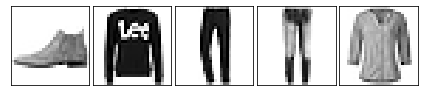

In [ ]:
# Display random images from the test set, the ground truth labels and the network's predictions
net.eval()
with torch.no_grad():
    images, labels = iter(testloader).next()
    tests.plot_images(images[:5], n_rows=1)
    
    # Compute predictions
    images = images.to(device)
    y = net(images)

print('Ground truth labels: ', ' '.join('%10s' % classes[labels[j]] for j in range(5)))
print('Predictions:         ', ' '.join('%10s' % classes[j] for j in y.argmax(dim=1)))

In [ ]:
# Compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)
assert accuracy > 0.85, "Poor accuracy {:.3f}".format(accuracy)
print('Success')

Accuracy of the network on the test images: 0.891
Success
